# Geo

1. Plot sample distribution on world map.
1. Plot timeline by study.

---
## Setup

### Import Modules

In [1]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import shapely
import treetime

### File Paths

In [2]:
metadata_path = "../../docs/results/latest/metadata/metadata.tsv"
outdir = "../../docs/results/latest/geo"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [3]:
from config import *

GEO_ATTR = "Province"
CRS="epsg:4326"
WEB_MERCATOR_CRS = "epsg:3857"
NAME_COL = "Sample"
DATE_COL = "Date"

SCRIPT_NAME = "geo"

### Import Dataframe as Pandas

In [4]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
metadata_df.fillna(NO_DATA_CHAR, inplace=True)
metadata_df.set_index("Sample", inplace=True)

### Parse Dates

In [5]:
dates_dict = treetime.utils.parse_dates(metadata_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)


Attempting to parse dates...
	Using column 'Sample' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


### Convert Dataframe to GeoPandas

In [6]:
# For samples with no province info, set to country
for rec in metadata_df.iterrows():
    sample = rec[0]
    data = rec[1]
    province = data["Province"]
    if province == NO_DATA_CHAR:
        # Try to set latlon to country
        country = data["Country"]
        if country != NO_DATA_CHAR:
            metadata_df.at[sample, "Province"] = data["Country"]
            metadata_df.at[sample, "ProvinceLat"] = data["CountryLat"]
            metadata_df.at[sample, "ProvinceLon"] = data["CountryLon"]
            

In [7]:
# Remove missing data
df = metadata_df[metadata_df[GEO_ATTR + "Lon"] != NO_DATA_CHAR]

geometry = [shapely.geometry.Point(xy) for xy in zip(df[GEO_ATTR + "Lon"], df[GEO_ATTR + "Lat"])]
#df = df.drop([GEO_ATTR + "Lon", GEO_ATTR + "Lat"], axis=1)
#WGS84 = "epsg:4326"
gdf_points = geopandas.GeoDataFrame(df, crs=CRS, geometry=geometry)

gdf_points

,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,geometry
Sample,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,NA,NA,NA,SAMN13632815,KEEP: Assembly Modern,POINT (40.79579 47.62225)
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,POINT (85.46335 42.48050)
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,POINT (85.46335 42.48050)
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,POINT (85.46335 42.48050)
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,POINT (85.46335 42.48050)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IP542,IP542,1952,-69,Kenya,Kenya,1.44197,38.4314,1.44197,38.4314,Antiqua,1.ANT,1.ANT1,IP542,KEEP: Local Modern,POINT (38.43140 1.44197)
IP543,IP543,1953,-68,Democratic Republic of the Congo,Democratic Republic of the Congo,-2.98143,23.8223,-2.98143,23.8223,Antiqua,1.ANT,1.ANT1,IP543,KEEP: Local Modern,POINT (23.82226 -2.98143)
IP557,IP557,1963,-58,Iran,Kurdistan,32.6475,54.5644,35.6728,47.0124,Medievalis,2.MED,2.MED1,IP557,KEEP: Local Modern,POINT (47.01244 35.67280)


### Prep Plotting Data

This should be a function, too repetitive

In [100]:
# --------------------------------------
# World Basemap
world_polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Data selection
# --------------------------------------
# Keller et al. 2019
gdf_keller = gdf_points[(gdf_points["BioSampleComment"].str.contains("Keller 2019")) & (gdf_points["BioSampleComment"].str.contains("Modern"))]
gdf_this_study = gdf_points[(gdf_points["BioSampleComment"].str.contains("Keller 2019")  == False ) & (gdf_points["BioSampleComment"].str.contains("Modern"))]
gdf_ancient = gdf_points[gdf_points["BioSampleComment"].str.contains("Ancient")]

plot_dict = {"Ancient DNA" : {
                  "gdf" : gdf_ancient,
                  "geo_count" : {},
                  "geo_size" : [],
                  "date_count" : {}, 
              },  
             "Keller et al. 2019" : {
                  "gdf" : gdf_keller,
                  "geo_count" : {},
                  "geo_size" : [],
                  "date_count" : {},   
              },
              "This Study" : {
                  "gdf" : gdf_this_study,
                  "geo_count" : {},
                  "geo_size" : [],
                  "date_count" : {},                      
              },            
             }

for dataset in plot_dict:
    # Iterate through records for each dataset
    gdf = plot_dict[dataset]["gdf"]
    for rec in gdf.iterrows():
        sample = rec[0]
        date = dates_dict[sample]
        geo = rec[1][GEO_ATTR]

        # Convert date to float and get mean if range
        if type(date) == list:
            date = sum(dates_dict[sample]) / 2
        date = float(date)     
        
        if date not in plot_dict[dataset]["date_count"]:
            plot_dict[dataset]["date_count"][date] = 0
        plot_dict[dataset]["date_count"][date] += 1   
        
        # Add geo info
        if geo not in plot_dict[dataset]["geo_count"]:
            plot_dict[dataset]["geo_count"][geo] = 0
        plot_dict[dataset]["geo_count"][geo] += 1   
        
    # Drop duplicate entries for geo plotting
    gdf = gdf.drop_duplicates(subset = GEO_ATTR, keep = 'first')
    for geo in gdf[GEO_ATTR]:
        size = plot_dict[dataset]["geo_count"][geo]
        plot_dict[dataset]["geo_size"].append(size)
        
    plot_dict[dataset]["gdf"] = gdf

### Plot

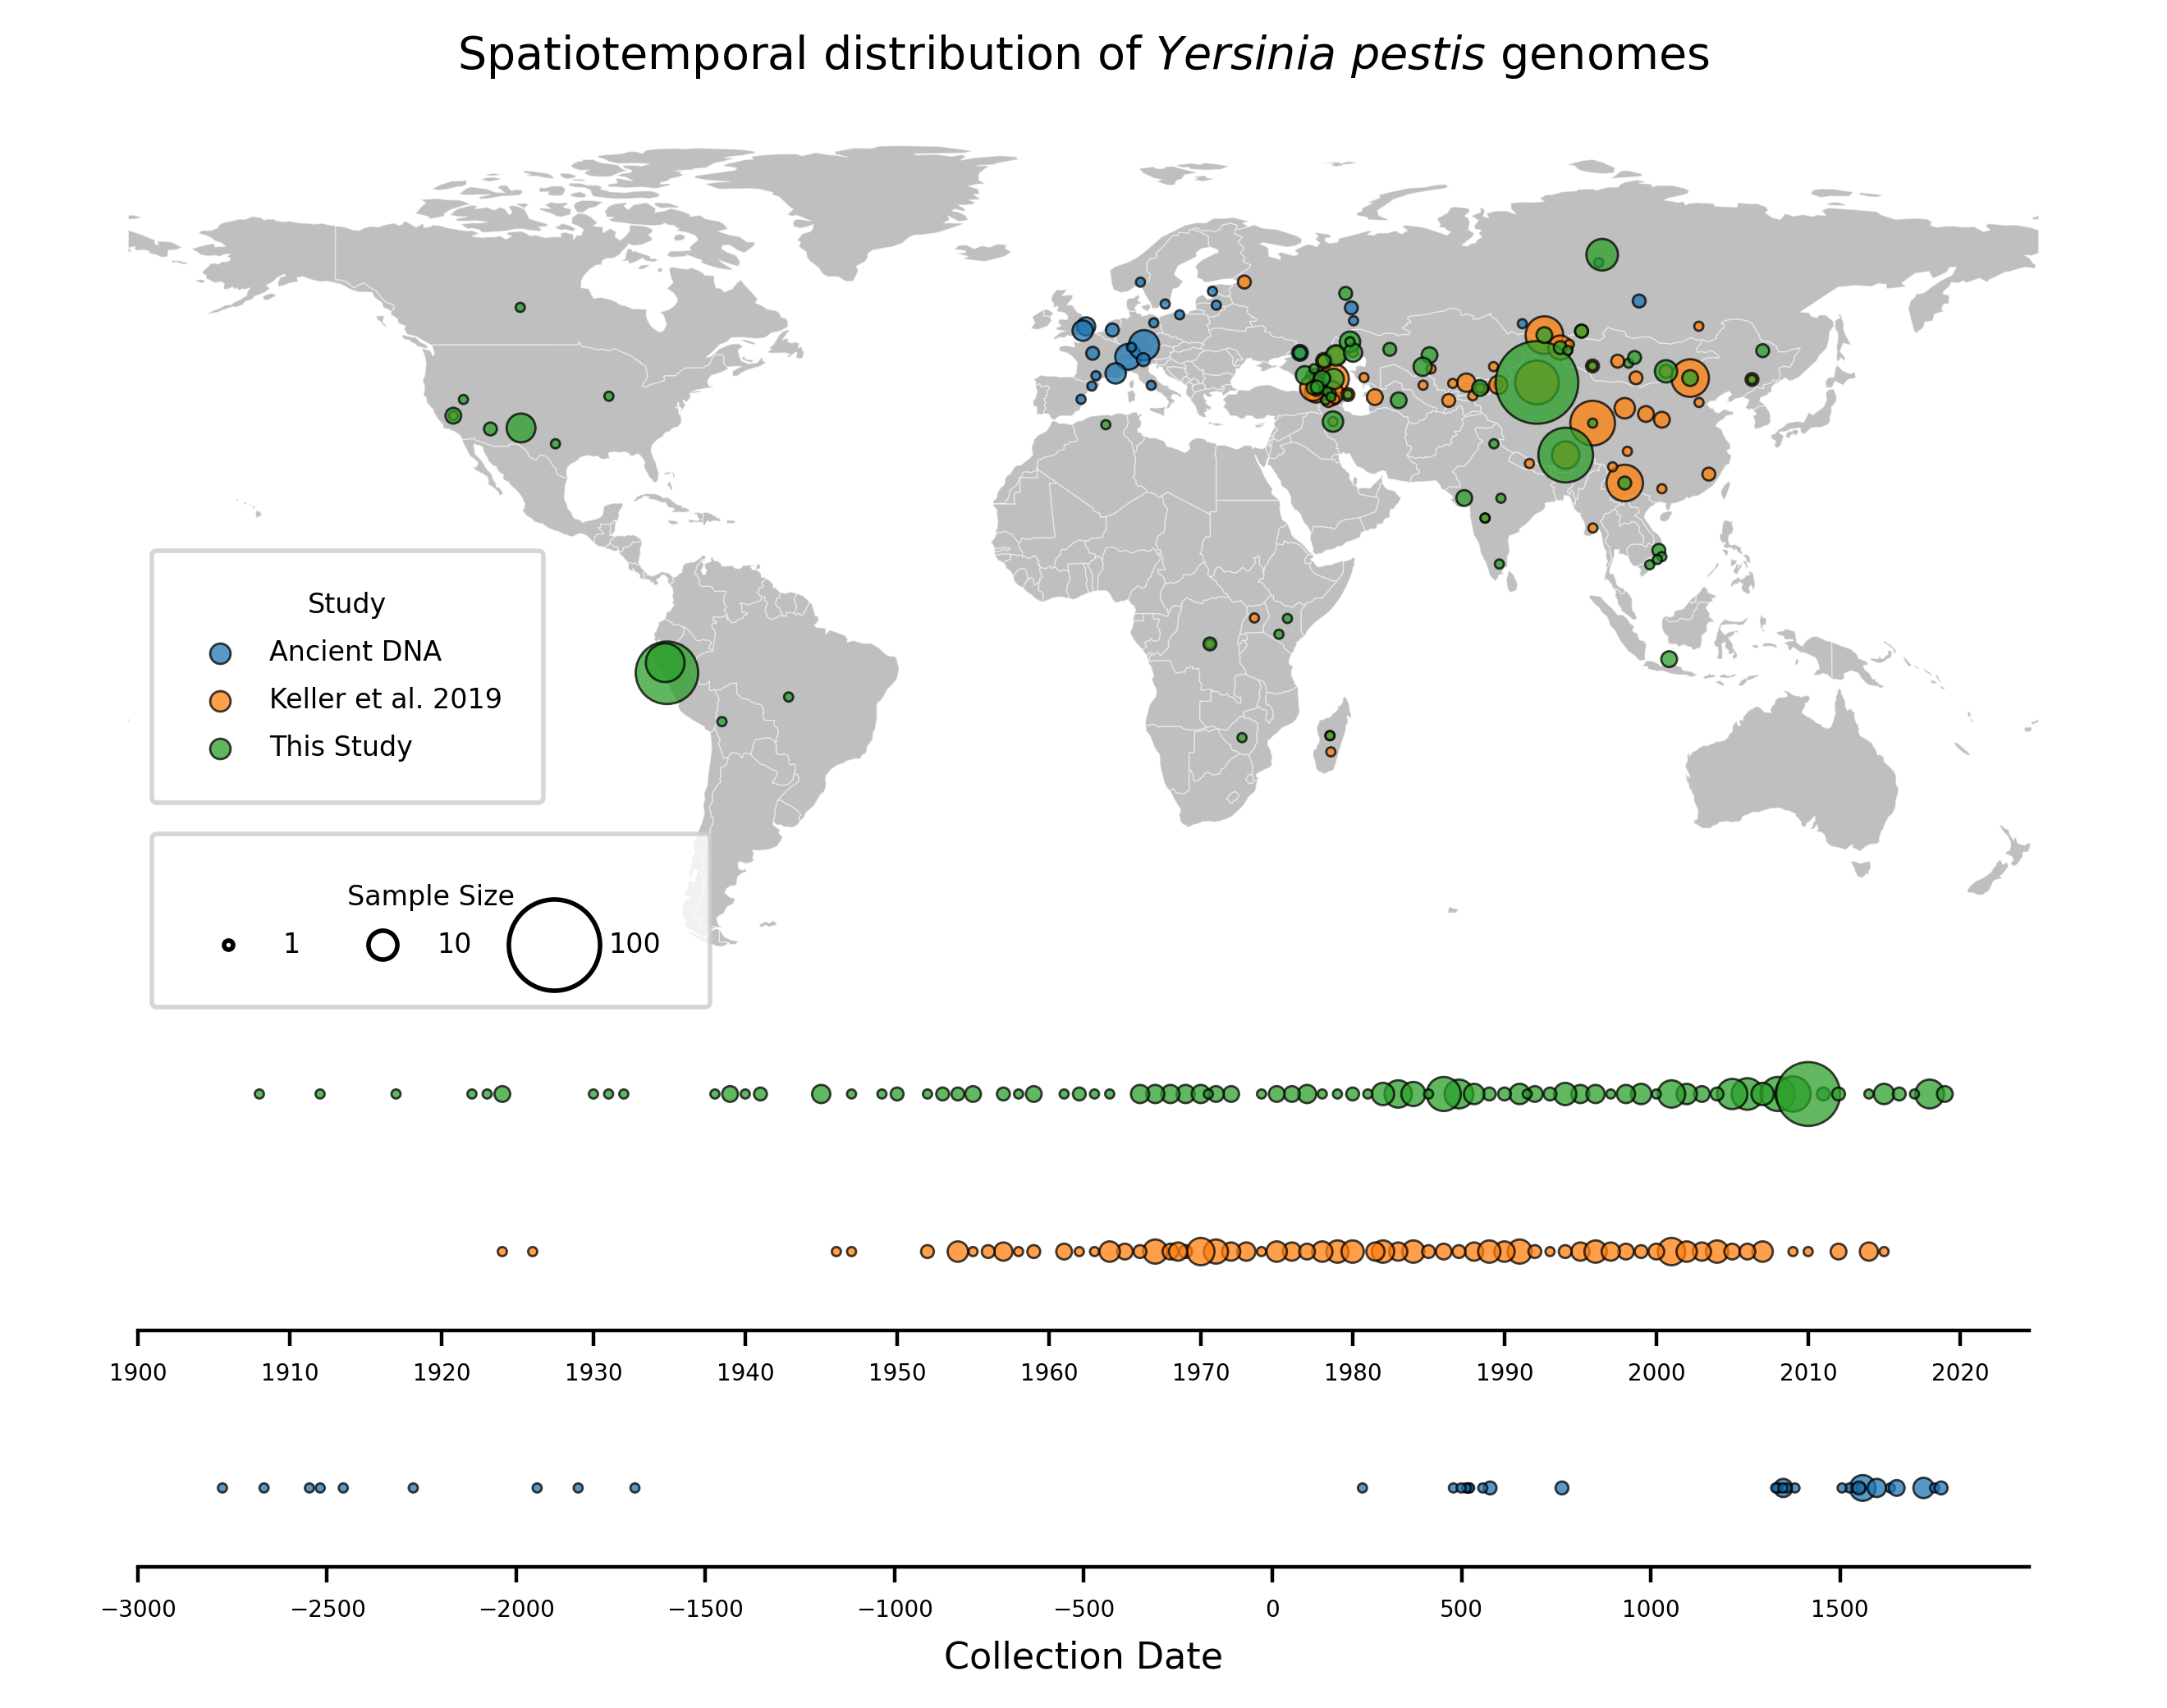

In [169]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0.05, 0, 0.9, 0.2])
ax3 = fig.add_axes([0.05, -0.15, 0.9, 0.1])

# Make everything appear larger
marker_scale = 4

# --------------------------------------
# World Basemap
world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.5, 
                    color="grey",
                    edgecolor="white", 
                    linewidth=0.25,
                   )

layer = 0
for dataset in plot_dict.keys():
    gdf = plot_dict[dataset]["gdf"]
    layer += 1
    # Plot map
    geo_size = plot_dict[dataset]["geo_size"]
    gdf.plot(ax=ax1, 
             zorder=layer, 
             markersize=[s*marker_scale for s in geo_size],
             color=DISC_CMAPLIST[layer-1],
             edgecolor="black",
             linewidths=0.5,
             label=dataset,
             legend=True,
             alpha=0.75,
             )

    # Plot timeline
    date_count = plot_dict[dataset]["date_count"]
    
    # Plot ancient timeline separately    
    if "Ancient" in dataset:
        ax3.scatter(x=list(date_count.keys()), 
                y=[layer for i in range(len(date_count))],
                s=[s*marker_scale for s in list(date_count.values())],
                zorder=layer,   
                color=DISC_CMAPLIST[layer-1],
                edgecolor="black",
                linewidths=0.5,
                alpha=0.75,
               )
      
    else:
        ax2.scatter(x=list(date_count.keys()), 
                y=[layer for i in range(len(date_count))],
                s=[s*marker_scale for s in list(date_count.values())],
                zorder=layer,   
                color=DISC_CMAPLIST[layer-1],
                edgecolor="black",
                linewidths=0.5,
                alpha=0.75,
               )

# --------------------------------------
# Limits

# Sorry Antarctica
ax1.set_ylim(-63,)

ax2.set_ylim(1.5,3.5)
ax3.set_xlim(-3000,2000)
# --------------------------------------
# Labels
ax1.set_title("Spatiotemporal distribution of " 
          + "$\it Yersinia$" 
          + " " 
          + "$\it pestis$"
          + " " 
          + "genomes")
ax1.axis('off')

ax2.set_xticks([x for x in range(1900,2021,10)])
ax2.set_yticks([])

ax3.set_xticks([x for x in range(-3000,2000,500)])
ax3.set_yticks([])

ax3.set_xlabel("Collection Date")

# --------------------------------------
# Layout
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(False)

#ax3.xaxis.tick_top()

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(False)


# --------------------------------------
# Legend

color_legend = ax1.legend(loc="center left",
                          bbox_to_anchor=(0.05, 0.35),
                          ncol=1,
                          borderpad = 1.5, 
                          title="Study", 
                          title_fontsize=6,
                          fontsize=6, 
                          frameon=True,
                         )
for handle in color_legend.legendHandles:
    handle.set_sizes([20])


size_l1  = plt.scatter([],[], s=1 * marker_scale, edgecolors='black', color="white")
size_l10 = plt.scatter([],[], s=10 * marker_scale, edgecolors='black', color="white")
size_l100 = plt.scatter([],[], s=100 * marker_scale, edgecolors='black', color="white")

size_labels = ["1", "10", "100"]

size_legend = plt.legend([size_l1, size_l10, size_l100], 
                 size_labels,
                 loc="center left", 
                 bbox_to_anchor=(0, 4.1),
                 ncol=3,
                 borderpad = 1.8, 
                 title="Sample Size", 
                 title_fontsize=6,
                 fontsize=6, 
                 frameon=True,
                 #labelspacing=2,
                 handletextpad=1,
                )
 
# Add multiple legends as artists
#ax1.add_artist(color_legend)
#ax1.add_artist(size_legend)


# --------------------------------------------
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_map_timeline." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## OLD

In [10]:
# --------------------------------------
# World Basemap
world_polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# --------------------------------------
# Keller et al. 2019
gdf_keller = gdf_points[(gdf_points["BioSampleComment"].str.contains("Keller 2019")) & (gdf_points["BioSampleComment"].str.contains("Modern"))]

# Store counts for sizes
gdf_keller_geo_count = {}
gdf_keller_date_count = {}

for rec in gdf_keller.iterrows():
    sample = rec[0]
    date = dates_dict[sample]
    geo = rec[1][GEO_ATTR]
    
    # Convert date to float and get mean if range
    if type(date) == list:
        # Use the mean
        date = sum(dates_dict[sample]) / 2
    date = float(date)        
    if date not in gdf_keller_date_count:
        gdf_keller_date_count[date] = 0
    gdf_keller_date_count[date] += 1
    
    if geo not in gdf_keller_geo_count:
        gdf_keller_geo_count[geo] = 0
    gdf_keller_geo_count[geo] += 1

# Drop duplicate entries for geo plotting
gdf_keller = gdf_keller.drop_duplicates(subset = GEO_ATTR, keep = 'first')

# Store a size list for plotting
gdf_keller_geo_size = []
for geo in gdf_keller[GEO_ATTR]:
    gdf_keller_geo_size.append(gdf_keller_geo_count[geo])
    
print(gdf_keller_geo_count)
print(gdf_keller_date_count)
"""
# --------------------------------------
# This study
gdf_this_study = gdf_points[(gdf_points["BioSampleComment"].str.contains("Keller 2019")  == False ) & (gdf_points["BioSampleComment"].str.contains("Modern"))]
# Get count of each location
gdf_this_study_count = {}
for geo in gdf_this_study[GEO_ATTR]:
    if geo not in gdf_this_study_count:
        gdf_this_study_count[geo] = 0
    gdf_this_study_count[geo] += 1

# Drop duplicate entries
gdf_this_study = gdf_this_study.drop_duplicates(subset = 'Province', keep = 'first')

# Store as list for plotting
gdf_this_study_size = []
for geo in gdf_this_study[GEO_ATTR]:
    gdf_this_study_size.append(gdf_this_study_count[geo])
    
# --------------------------------------
# Ancient Samples 
gdf_ancient = gdf_points[gdf_points["BioSampleComment"].str.contains("Ancient")]
# Get count of each location
gdf_ancient_count = {}
for geo in gdf_ancient[GEO_ATTR]:
    if geo not in gdf_ancient_count:
        gdf_ancient_count[geo] = 0
    gdf_ancient_count[geo] += 1

# Drop duplicate entries
gdf_ancient = gdf_ancient.drop_duplicates(subset = 'Province', keep = 'first')


# Store as list for plotting
gdf_ancient_size = []
for geo in gdf_ancient[GEO_ATTR]:
    gdf_ancient_size.append(gdf_ancient_count[geo])   """ 

{'Naryn Region': 1, 'Uganda': 1, 'Madagascar': 1, 'Xinjiang': 23, 'Yunnan': 16, 'Province de Fianarantsoa': 1, 'Maharashtra': 1, 'West Kazakhstan Region': 1, 'Astrakhan Oblast': 4, 'Republic of Dagestan': 11, 'Altai Republic': 17, 'Goranboy District': 7, 'Shirak Province': 6, 'Bayan-Ölgii': 7, 'Talas Region': 4, 'Sughd Province': 2, 'Bayankhongor': 2, 'Omnogovi': 1, 'Ömnögovi': 2, 'Issyk-Kul Region': 4, 'Syunik Province': 2, 'Gegharkunik Province': 1, 'Baku': 2, 'Fizuli District': 1, 'Tuva Republic': 2, 'Kyzylorda Province': 1, 'Kabardino-Balkaria': 3, 'Republic of Kalmykia': 3, 'Osh Region': 1, 'Shymkent': 1, 'Almaty Region': 1, 'Navoiy Region': 1, 'Atyrau': 1, 'Mangystau Province': 1, 'Balkan': 3, 'Ingushetia': 1, 'Zabaykalsky Krai': 1, 'Samtskhe-Javakheti': 8, 'Kurdistan': 1, 'Inner Mongolia': 17, 'Democratic Republic of the Congo': 1, 'Lanzou': 1, 'Kyrgyzstan': 1, 'Gandaki Pradesh': 1, 'California': 1, 'Guangxi Zhuang': 1, 'Myanmar': 1, 'Shaanxi': 3, 'Govi-Altai': 2, 'Dornogovi': 2

'\n# --------------------------------------\n# This study\ngdf_this_study = gdf_points[(gdf_points["BioSampleComment"].str.contains("Keller 2019")  == False ) & (gdf_points["BioSampleComment"].str.contains("Modern"))]\n# Get count of each location\ngdf_this_study_count = {}\nfor geo in gdf_this_study[GEO_ATTR]:\n    if geo not in gdf_this_study_count:\n        gdf_this_study_count[geo] = 0\n    gdf_this_study_count[geo] += 1\n\n# Drop duplicate entries\ngdf_this_study = gdf_this_study.drop_duplicates(subset = \'Province\', keep = \'first\')\n\n# Store as list for plotting\ngdf_this_study_size = []\nfor geo in gdf_this_study[GEO_ATTR]:\n    gdf_this_study_size.append(gdf_this_study_count[geo])\n    \n# --------------------------------------\n# Ancient Samples \ngdf_ancient = gdf_points[gdf_points["BioSampleComment"].str.contains("Ancient")]\n# Get count of each location\ngdf_ancient_count = {}\nfor geo in gdf_ancient[GEO_ATTR]:\n    if geo not in gdf_ancient_count:\n        gdf_ancient_

NameError: name 'gdf_ancient_size' is not defined

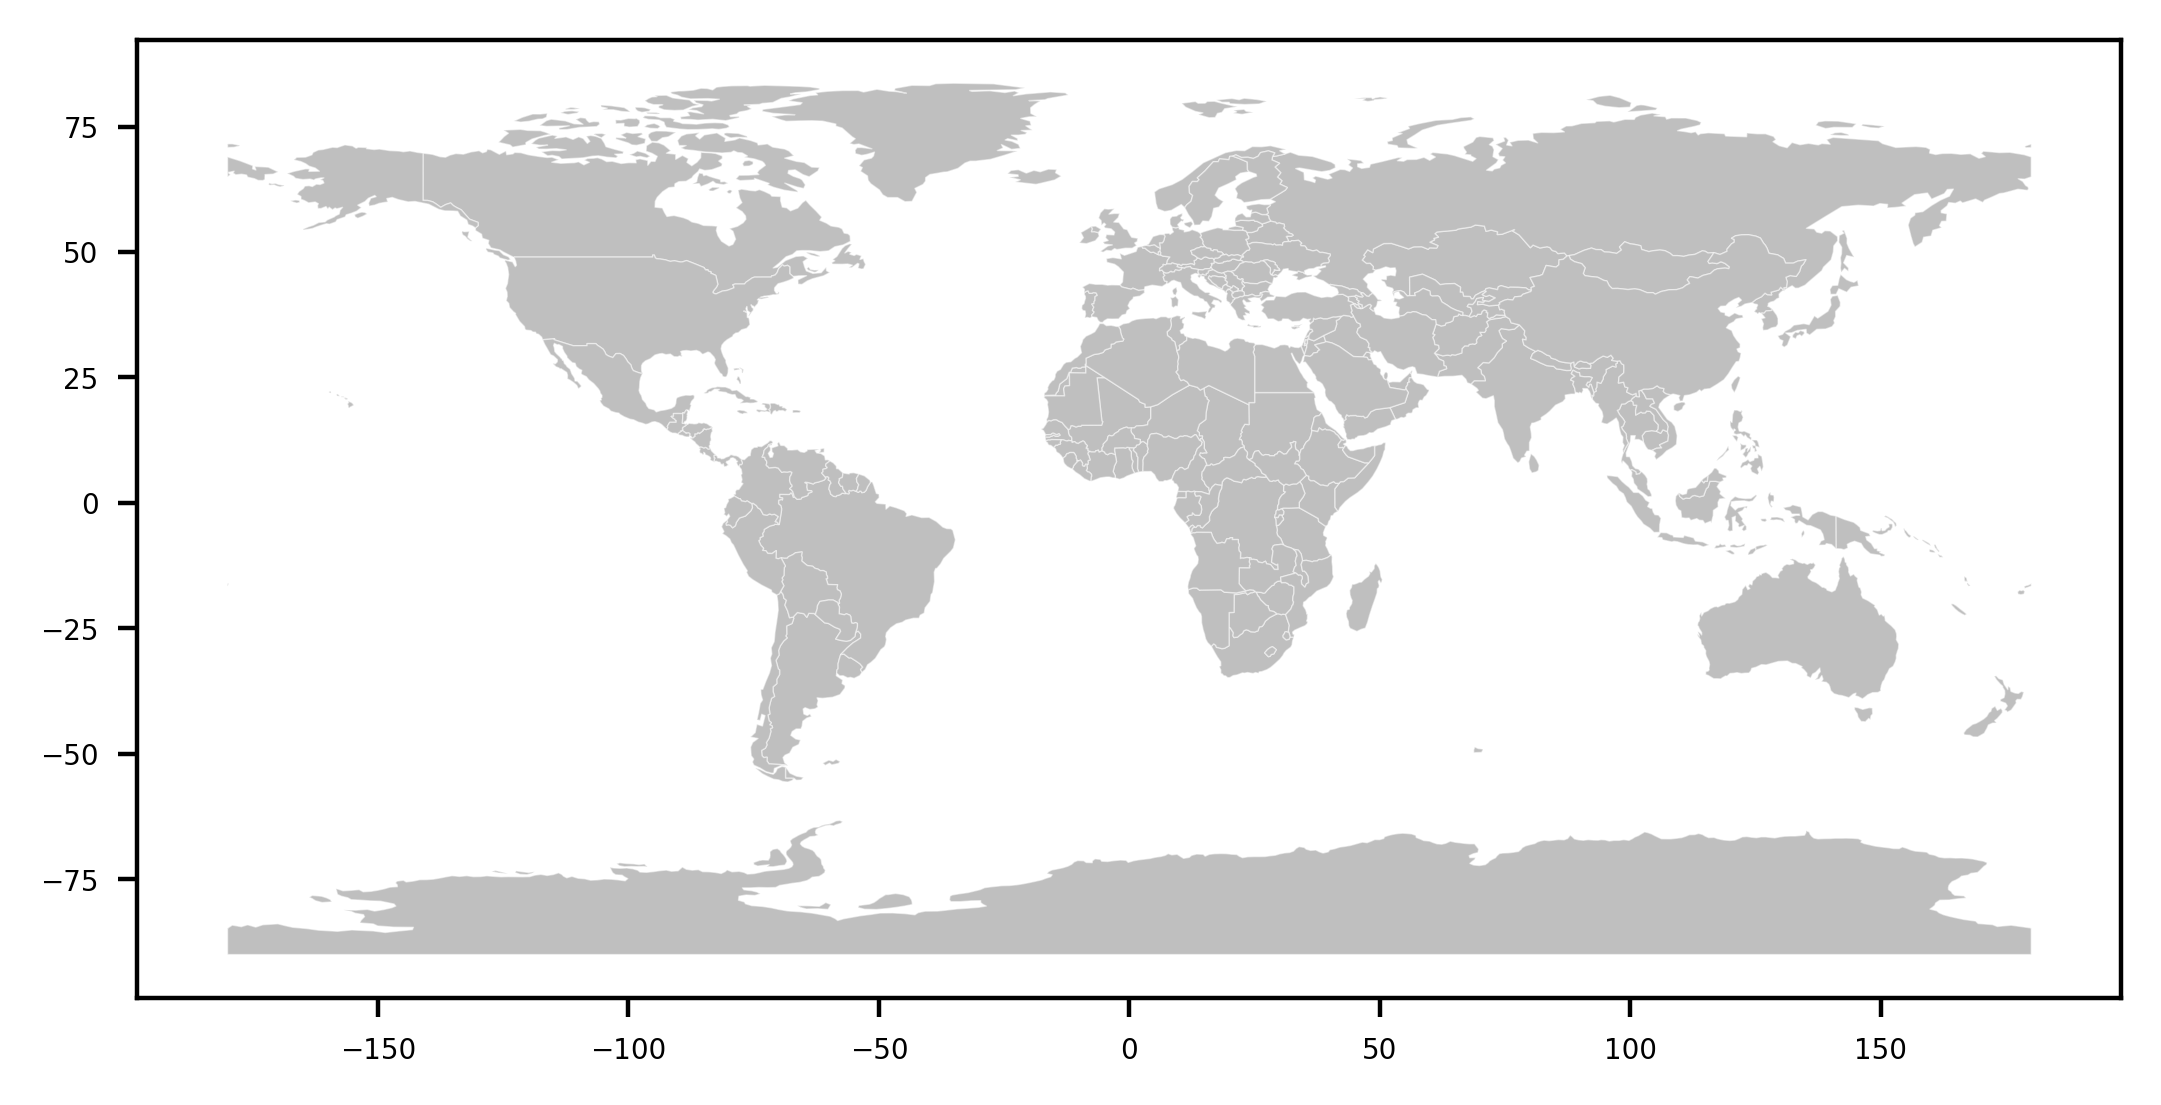

In [11]:
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize)

# Make everything appear larger
marker_scale = 4

# --------------------------------------
# World Basemap
world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.5, 
                    color="grey",
                    edgecolor="white", 
                    linewidth=0.25,
                   )


# --------------------------------------
# Ancient
gdf_ancient.plot(ax=ax1, 
                zorder=2, 
                markersize=[s*marker_scale for s in gdf_ancient_size], 
                color=DISC_CMAPLIST[2],
                edgecolor="black",
                linewidths=0.5,
                label="Ancient",
                legend=True,
                alpha=0.75,
                )


# --------------------------------------
# Keller et al. 2019
gdf_keller.plot(ax=ax1, 
                zorder=3, 
                markersize=[s*marker_scale for s in gdf_keller_size], 
                color=DISC_CMAPLIST[0],
                edgecolor="black",
                linewidths=0.5,
                label="Keller et al. 2019 (Modern)",
                legend=True,
                alpha=0.75,
                )

# --------------------------------------
# This study
gdf_this_study.plot(ax=ax1, 
                zorder=4, 
                markersize=[s*marker_scale for s in gdf_this_study_size], 
                color=DISC_CMAPLIST[1],
                edgecolor="black",
                linewidths=0.5,
                label="This Study (Modern)",
                legend=True,
                alpha=0.75,
                )

# --------------------------------------
# Limits

# Sorry Antarctica
ax1.set_ylim(-63,)

# --------------------------------------
# Labels
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_title("Sampling distribution of " 
          + "$\it Yersinia$" 
          + " " 
          + "$\it pestis$"
          + " " 
          + "genomes")
ax1.axis('off')
# --------------------------------------
# Legend
legend = plt.legend(frameon=True, markerscale=None)
for handle in legend.legendHandles:
    handle.set_sizes([20])
    
size_l1  = plt.scatter([],[], s=1 * marker_scale, edgecolors='black', color="white")
size_l10 = plt.scatter([],[], s=10 * marker_scale, edgecolors='black', color="white")
size_l100 = plt.scatter([],[], s=100 * marker_scale, edgecolors='black', color="white")

size_labels = ["1", "10", "100"]

size_legend = plt.legend([size_l1, size_l10, size_l100], 
                 size_labels,
                 loc="center left", 
                 bbox_to_anchor=(0.0475, 0),
                 ncol=3,
                 borderpad = 1.8, 
                 title="Samples", 
                 title_fontsize=6,
                 fontsize=6, 
                 frameon=True,
                 #labelspacing=2,
                 handletextpad=1,
                )

color_legend = ax1.legend(loc="center left",
                          bbox_to_anchor=(0.05, 0.3),
                          ncol=1,
                          borderpad = 1.5, 
                          title="Study", 
                          title_fontsize=6,
                          fontsize=4, 
                          frameon=True,
                         )

for handle in color_legend.legendHandles:
    handle.set_sizes([20])
    
# Add multiple legends as artists
ax1.add_artist(color_legend)
ax1.add_artist(size_legend)


# --------------------------------------------
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_global_study." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
## Timeline

### Prep Time Plot Data

In [ ]:
# --------------------------------------
# This Study
gdf_this_study = gdf_points[(gdf_points["BioSampleComment"].str.contains("Keller 2019")  == False ) & (gdf_points["BioSampleComment"].str.contains("Modern"))]

# Get count of each date
gdf_this_study_count = {}

for rec in gdf_this_study.iterrows():
    # Convert to float and get mean if range
    sample = rec[0]
    date = dates_dict[sample]
    if type(date) == list:
        # Use the mean
        date = sum(dates_dict[sample]) / 2
    # Convert to float
    date = float(date)
        
    if date not in gdf_this_study_count:
        gdf_this_study_count[date] = 0
    gdf_this_study_count[date] += 1

# --------------------------------------
# Keller et al. 2019
gdf_keller = gdf_points[(gdf_points["BioSampleComment"].str.contains("Keller 2019")) & (gdf_points["BioSampleComment"].str.contains("Modern"))]

# Get count of each date
gdf_keller_count = {}

for rec in gdf_keller.iterrows():
    # Convert to float and get mean if range
    sample = rec[0]
    date = dates_dict[sample]
    if type(date) == list:
        # Use the mean
        date = sum(dates_dict[sample]) / 2
    # Convert to float
    date = float(date)
        
    if date not in gdf_keller_count:
        gdf_keller_count[date] = 0
    gdf_keller_count[date] += 1

In [ ]:
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize)

# Make everything appear larger
marker_scale = 10
# --------------------------------------
# Keller et al. 2019
ax1.scatter(x=list(gdf_keller_count.keys()), 
            y=[0.5 for i in range(len(gdf_keller_count))],
            s=[s*marker_scale for s in list(gdf_keller_count.values())],
            color=DISC_CMAPLIST[0],
            edgecolor="black",
            linewidths=0.5,
            alpha=0.75,
           )

# --------------------------------------
# This Study
ax1.scatter(x=list(gdf_this_study_count.keys()), 
            y=[0 for i in range(len(gdf_this_study_count))],
            s=[s*marker_scale for s in list(gdf_this_study_count.values())],
            color=DISC_CMAPLIST[1],
            edgecolor="black",
            linewidths=0.5,
            alpha=0.75,
           )

x_buffer = 5
y_buffer = 1
ax1.set_ylim(0-y_buffer,2+y_buffer)
ax1.set_xlim(1900-x_buffer,2020+x_buffer)
        